# Load & understand the data

In [ ]:
# imports
import pandas as pd
import ast
from matplotlib_venn import venn3
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_labels = pd.read_csv("10k_open_source_labels.csv")

In [ ]:
data_labels.head(5)

,file,kube_linter_eids,kube_linter_new_eids,terrascan_eids,terrascan_new_eids,checkov_eids,checkov_new_eids
0,manifest193566.yaml,['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167']
1,manifest193567.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0072', 'AC_K8S_0070', 'AC_K8S_0078', ...","['LLM_error_41', 'LLM_error_14', 'LLM_error_43...","['CKV_K8S_20', 'CKV_K8S_11', 'CKV_K8S_30', 'CK...","['LLM_error_8', 'LLM_error_1', 'LLM_error_28',..."
2,manifest193568.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0086', 'AC_K8S_0085', 'AC_K8S_0064', ...","['LLM_error_9', 'LLM_error_52', 'LLM_error_28'...","['CKV_K8S_20', 'CKV_K8S_30', 'CKV_K8S_21', 'CK...","['LLM_error_8', 'LLM_error_28', 'LLM_error_9',..."
3,manifest193569.yaml,['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167'],['no_error'],['LLM_error_167']
4,manifest19356.yaml,"['default-service-account', 'dnsconfig-options...","['LLM_error_12', 'LLM_error_145', 'LLM_error_1...","['AC_K8S_0085', 'AC_K8S_0098', 'AC_K8S_0097', ...","['LLM_error_52', 'LLM_error_1', 'LLM_error_169...","['CKV_K8S_20', 'CKV_K8S_11', 'CKV_K8S_10', 'CK...","['LLM_error_8', 'LLM_error_1', 'LLM_error_22',..."


We an see that the data (from 10k_open_source_labels.csv) stores information about different static analysis or security scanning tools (kube-linter, terrascan, and checkov) when applied to various files, listing the specific errors found by each tool for each file.

In [ ]:
labels_mapping = pd.read_json('misconfigs_map.json')

The miconfigs map data maps between the error IDs and their description in each one of the 3 different error detection scanners. If there is None in one of the scanners, it means that this error is not detected / covered by this scanner.

In [ ]:
manifests_mapping = pd.read_json('10k_open_source_manifests.json')
manifests_mapping.head(5)

,file,file_content
0,manifest193566.yaml,"apiVersion: ""networking.k8s.io/v1""\nkind: ""Ing..."
1,manifest193567.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...
2,manifest193568.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...
3,manifest193569.yaml,apiVersion: v1\nkind: PersistentVolumeClaim\nm...
4,manifest19356.yaml,# Copyright 2016 The Kubernetes Authors All ri...


In [ ]:
manifests_mapping

,file,file_content
0,manifest193566.yaml,"apiVersion: ""networking.k8s.io/v1""\nkind: ""Ing..."
1,manifest193567.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...
2,manifest193568.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...
3,manifest193569.yaml,apiVersion: v1\nkind: PersistentVolumeClaim\nm...
4,manifest19356.yaml,# Copyright 2016 The Kubernetes Authors All ri...
...,...,...
9995,manifest201771.yaml,apiVersion: v1\nkind: Service\nmetadata:\n na...
9996,manifest201772.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...
9997,manifest201773.yaml,apiVersion: v1\nkind: Service\nmetadata:\n la...
9998,manifest201774.yaml,apiVersion: apps/v1\nkind: Deployment\nmetadat...


This data mapps between the yamls files and their content.

# Data Exploration

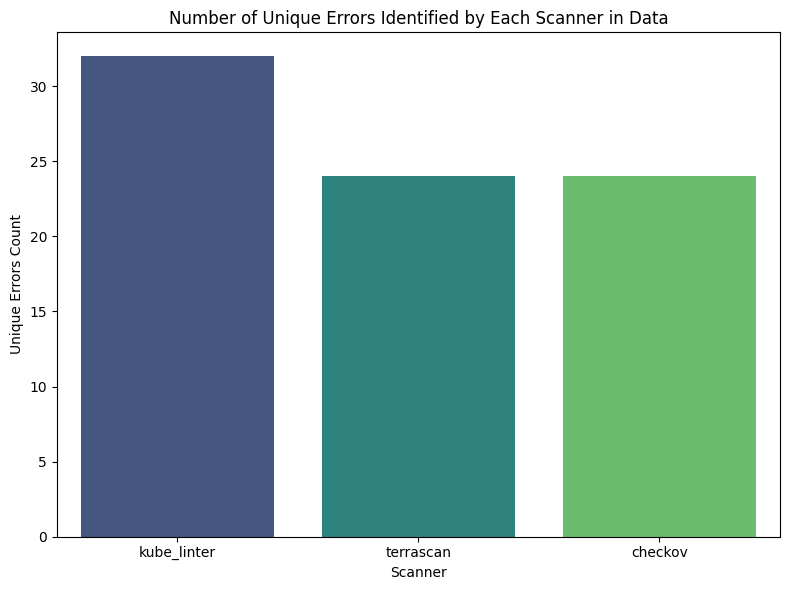

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

unique_errors_df = pd.DataFrame(list(unique_errors_per_tool.items()), columns=['Scanner', 'Unique Errors Found in Data'])

plt.figure(figsize=(8, 6))
sns.barplot(data=unique_errors_df, x='Scanner', y='Unique Errors Found in Data', palette='viridis', hue='Scanner', legend=False)
plt.title("Number of Unique Errors Identified by Each Scanner in Data")
plt.xlabel("Scanner")
plt.ylabel("Unique Errors Count")
plt.tight_layout()
plt.show()

This illustrates the number of unique errors found by each scanner within the provided dataset (data_labels). It appears that the kube_linter scanner has identified a significantly higher number of unique error types compared to Terrascan and Checkov in our specific dataset.

In [ ]:
def safe_eval(x):
  # as each tool contains a list of errors, the lists are strings (not python list)
  if pd.isna(x) or x.strip() == "":
      return []
  try:
      val = ast.literal_eval(x)
      return val if isinstance(val, list) else []
  except:
      return []
error_cols = [
    'kube_linter_eids', 'kube_linter_new_eids',
    'terrascan_eids', 'terrascan_new_eids',
    'checkov_eids', 'checkov_new_eids'
]

for col in error_cols:
    data_labels[col] = data_labels[col].apply(safe_eval)

## Total errors detected in given yaml files, divided by tool

In [ ]:
def count_errors(df, col):
    return sum(len(e) for e in df[col])

tools = ['kube_linter', 'terrascan', 'checkov']
for tool in tools:
    print(f"{tool} errors: {count_errors(data_labels, f'{tool}_eids')}")
    print(f"{tool} NEW errors: {count_errors(data_labels, f'{tool}_new_eids')}")

kube_linter errors: 79343
kube_linter NEW errors: 79343
terrascan errors: 57722
terrascan NEW errors: 57722
checkov errors: 78660
checkov NEW errors: 78660


## Error coverage by each tool


<ipython-input-23-5536ff279aa6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tool_coverage_counts, x='Tool', y='Error Types Covered', palette='Set2')


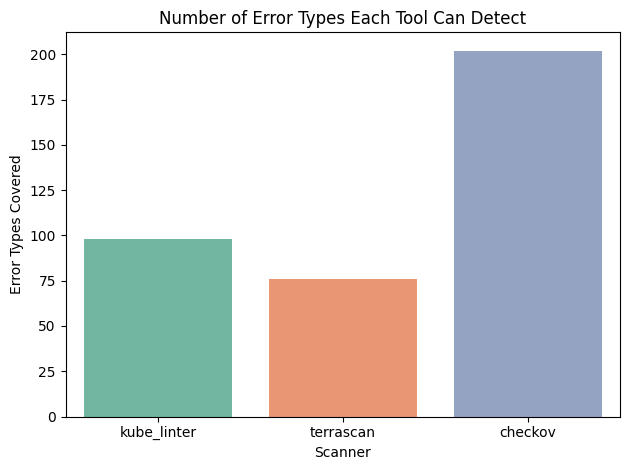

In [ ]:


# Only use the relevant scanner columns
scanner_columns = ['kube_linter', 'terrascan', 'checkov']
tool_coverage_counts = labels_mapping[scanner_columns].notna().sum().rename_axis('Tool').reset_index(name='Error Types Covered')

# Plot
sns.barplot(data=tool_coverage_counts, x='Tool', y='Error Types Covered', palette='Set2')
plt.title("Number of Error Types Each Tool Can Detect")
plt.xlabel("Scanner")
plt.ylabel("Error Types Covered")
plt.tight_layout()
plt.show()


## Comparison Between tools' covered errors

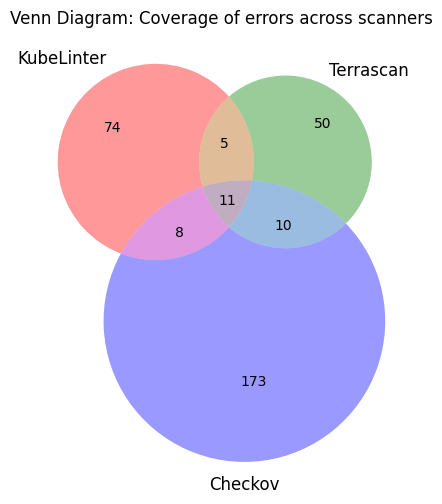

In [ ]:

kube_eids = set(labels_mapping[labels_mapping['kube_linter'].notna()].index)
terrascan_eids = set(labels_mapping[labels_mapping['terrascan'].notna()].index)
checkov_eids = set(labels_mapping[labels_mapping['checkov'].notna()].index)

# Plot Venn diagram showing overlaps in coverage
plt.figure(figsize=(8, 6))
venn3([kube_eids, terrascan_eids, checkov_eids],
      set_labels=('KubeLinter', 'Terrascan', 'Checkov'))
plt.title("Venn Diagram: Coverage of errors across scanners")
plt.show()